In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset


### Movie lens Dataset
Reading dataset (MovieLens 1M movie ratings dataset: downloaded from https://grouplens.org/datasets/movielens/1m/)


In [ ]:
import os
import zipfile
from os.path import exists
cwd = os.getcwd()
file_exists = exists('./ml-1m/movies.dat')
if(file_exists==False):
      
        print('downloading....')
        os.system('curl -o ml-1m.zip -SL https://files.grouplens.org/datasets/movielens/ml-1m.zip')
        print('download Complete')
        print('Extracting..')
        savePath=cwd
        savefile="./ml-1m.zip"
        with zipfile.ZipFile(savefile, 'r') as zip_ref:
            zip_ref.extractall(savePath)
        print('Complete')

In [ ]:

movie_data = pd.io.parsers.read_csv('ml-1m/movies.dat',
    names=['movie_id', 'title', 'genre'],
    engine='python', delimiter='::')

movie_data

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### Visualise different genre

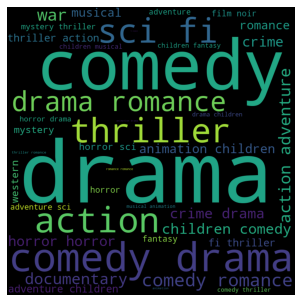

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in movie_data.genre:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 4).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
data = pd.io.parsers.read_csv('ml-1m/ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
    engine='python', delimiter='::')

data

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
user_ratingCount = (data.
     groupby(by = ['user_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalratingbyuser'})
     [['user_id', 'totalratingbyuser']]
    )
user_ratingCount.head(10)

,user_id,totalratingbyuser
0,1,53
1,2,129
2,3,51
3,4,21
4,5,198
5,6,71
6,7,31
7,8,139
8,9,106
9,10,401


In [ ]:

movie_ratingCount = (data.
     groupby(by = ['movie_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['movie_id', 'totalRatingCount']]
    )
movie_ratingCount.head()

,movie_id,totalRatingCount
0,1,2077
1,2,701
2,3,478
3,4,170
4,5,296


In [ ]:
rating_df_totalRatingCount = data.merge(movie_ratingCount, left_on = 'movie_id', right_on = 'movie_id', how = 'left')
rating_df_totalRatingCount.head()

,user_id,movie_id,rating,time,totalRatingCount
0,1,1193,5,978300760,1725
1,1,661,3,978302109,525
2,1,914,3,978301968,636
3,1,3408,4,978300275,1315
4,1,2355,5,978824291,1703


In [ ]:
rating_df_totalRatingCount= rating_df_totalRatingCount.merge( user_ratingCount, left_on = 'user_id', right_on = 'user_id', how = 'left')
rating_df_totalRatingCount.head()

,user_id,movie_id,rating,time,totalRatingCount,totalratingbyuser
0,1,1193,5,978300760,1725,53
1,1,661,3,978302109,525,53
2,1,914,3,978301968,636,53
3,1,3408,4,978300275,1315,53
4,1,2355,5,978824291,1703,53


In [ ]:

data= rating_df_totalRatingCount.query('totalRatingCount >= 200')
data= data.query('totalratingbyuser >= 100')
data.head()

,user_id,movie_id,rating,time,totalRatingCount,totalratingbyuser
53,2,1357,5,978298709,548,129
54,2,3068,4,978299000,379,129
55,2,1537,4,978299620,350,129
56,2,647,3,978299351,441,129
57,2,2194,4,978299297,1127,129


### Prepare Train and Test set

- We will consider 10 most recent rated movies by each user as testing data.Out model will be trained on rest of the data

In [ ]:
data=data.sort_values(by=['user_id','time'], ascending=[False,False]) 
data.shape

(718125, 6)

In [ ]:
test_df=data.groupby('user_id').head(30)
test_df.shape

(88350, 6)

In [ ]:
data=data[~data.isin(test_df).all(1)]
data.shape

(629775, 6)

## Final dataset

In [ ]:
data.head(1)

,user_id,movie_id,rating,time,totalRatingCount,totalratingbyuser
999943,6040,3819,5,963272166,245,341


In [ ]:
movie_data.head(1)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy


In [ ]:
test_df.head(1)

,user_id,movie_id,rating,time,totalRatingCount,totalratingbyuser
1000042,6040,1221,4,998315055,1692,341


## Applying Collaborative Filtering:
- We can apply any standard collaborative filtering  techniques.

## Singular Value Decomposition (SVD) based  Recommendation

###  Step1: Create the rating matrix with rows as movies and columns as users.

In [ ]:
ratings_mat = np.ndarray(
    shape=(np.max(data.movie_id.values), np.max(data.user_id.values)),
    dtype=np.uint8)
ratings_mat[data.movie_id.values-1, data.user_id.values-1] = data.rating.values

### Apply SVD

In [ ]:
from scipy.sparse.linalg import svds
normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T
n_factors = 50
#Computing the Singular Value Decomposition (SVD)
A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = svds (A,n_factors)

In [ ]:
movie_factors = V.T
user_factors = U

In [ ]:
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id - 1 # Movie id starts from 1 in the dataset
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]


### Recommendation for movie GoldenEye (1995)

In [ ]:
movie_id =movie_data[movie_data['title']=='GoldenEye (1995)']
movie_id=movie_id.values[0][0]

top_n = 10
k = 50
top_n = 10
sliced = movie_factors[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)
indexes=indexes+1
movie_data[movie_data['movie_id'].isin(indexes)]


,movie_id,title,genre
9,10,GoldenEye (1995),Action|Adventure|Thriller
345,349,Clear and Present Danger (1994),Action|Adventure|Thriller
1673,1722,Tomorrow Never Dies (1997),Action|Romance|Thriller
1937,2006,"Mask of Zorro, The (1998)",Action|Adventure|Romance
2921,2990,Licence to Kill (1989),Action
2922,2991,Live and Let Die (1973),Action
2924,2993,Thunderball (1965),Action
3013,3082,"World Is Not Enough, The (1999)",Action|Thriller
3564,3633,On Her Majesty's Secret Service (1969),Action
3570,3639,"Man with the Golden Gun, The (1974)",Action


In [ ]:

movie_id =movie_data[movie_data['title']=='Star Wars: Episode IV - A New Hope (1977)']
movie_id=movie_id.values[0][0]

top_n = 10
k = 50
top_n = 10
sliced = movie_factors[:, :k] # representative data
indexes = top_cosine_similarity(sliced, movie_id, top_n)
indexes=indexes+1
movie_data[movie_data['movie_id'].isin(indexes)]

,movie_id,title,genre
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1303,1323,Amityville 3-D (1983),Horror
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
2896,2965,"Omega Code, The (1999)",Action
3245,3314,"Big Trees, The (1952)",Action|Drama
3744,3813,Interiors (1978),Drama


## Evaluate our result
- We will generate top 10 recommendations for 200 user and calculate the hit rate in test data set.

In [ ]:
userlist=list(data.user_id.unique())[:200]

In [ ]:
data=data[data['user_id'].isin(userlist)]

In [ ]:
test_df=test_df[test_df['user_id'].isin(userlist)]

In [ ]:
result=data.sort_values(by=['user_id','time'],ascending=[True,False])
result=result.groupby('user_id').head(15)

In [ ]:
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['user_id']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
        
    movieid=row['movie_id'] 
  
    sliced = movie_factors[:, :k] # representative data
    indexes = top_cosine_similarity(sliced, movieid, top_n=5)
    indexes=indexes+1
    for ids in indexes:
        if(ids==movieid):
            continue
        if(~((result['movie_id'] == ids) & (result['user_id'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [ ]:
# Iterating over values
recommendations=[]
for userid, movies in recommend_dict.items():
    total=0
    mlist=[]
    for i in movies:
        total+=1
        mlist.append(i)
        if(total>15):
            break
    recommendations.append([userid,mlist])

In [ ]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','movies'])

In [ ]:
recommendations.head(2) 

,user_id,movies
0,5645,"[3253, 2321, 1641, 441, 2858, 2997, 2686, 1183..."
1,5646,"[2372, 2794, 2378, 3698, 2405, 2450, 2422, 241..."


In [ ]:
recommend_6040=recommendations[recommendations.user_id==6040]
recommend_6040=list(recommend_6040.movies)[0]

In [ ]:
movie_data[movie_data.movie_id.isin(recommend_6040)]

,movie_id,title,genre
229,232,Eat Drink Man Woman (1994),Comedy|Drama
290,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
303,306,Three Colors: Red (1994),Drama
898,910,Some Like It Hot (1959),Comedy|Crime
909,921,My Favorite Year (1982),Comedy
1116,1132,Manon of the Spring (Manon des sources) (1986),Drama
1260,1280,Raise the Red Lantern (1991),Drama
1319,1340,Bride of Frankenstein (1935),Horror
1333,1354,Breaking the Waves (1996),Drama
1685,1734,My Life in Pink (Ma vie en rose) (1997),Comedy|Drama


In [ ]:
recommendations

,user_id,movies
0,5645,"[3253, 2321, 1641, 441, 2858, 2997, 2686, 1183..."
1,5646,"[2372, 2794, 2378, 3698, 2405, 2450, 2422, 241..."
2,5647,"[3074, 2921, 2922, 1283, 3633, 3635, 2662, 236..."
3,5648,"[2353, 1527, 2058, 733, 480, 780, 2628, 589, 3..."
4,5649,"[3686, 2803, 3101, 454, 1457, 236, 276, 339, 3..."
...,...,...
195,6035,"[2598, 2581, 2772, 785, 2321, 1777, 2567, 3255..."
196,6036,"[379, 2808, 173, 3697, 1603, 1590, 172, 160, 1..."
197,6037,"[2859, 3424, 162, 1189, 2248, 357, 2918, 915, ..."
198,6039,"[2863, 3545, 3552, 1772, 2000, 2791, 914, 1088..."


### Calculate Hit Ratio
- See how often we recommended a movie the user actually rated

In [ ]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.movies)[0]
    total+=1
    for rs in results:
        
        if(((test_df['movie_id'] == rs) & (test_df['user_id'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.725
